In [1]:
#从已有模型finetuning
# config=[
#     "--logdir", "./runs/model_test/main_model",
#     "--model_suffix", "free",
# ]
import os
os.environ['ON_PY']="1"

from params import parser

from model.PPO import PPO
from train.base import *
import numpy.ma as ma

(CVXPY) Mar 21 10:11:38 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 21 10:11:38 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:

class PPOT(PPO):
    def __init__(self, config):
        super().__init__(config)


    def update(self, memory, freeze_feature_exact = False):
        '''
        :param memory: data used for PPO training
        :return: total_loss and critic_loss
        '''

        # 获取转置后的训练数据，用于策略更新
        t_data = memory.transpose_data()  # Tensor len 13  pre torch.Size([1000, 50, 10])
        # 计算广义优势估计（GAE）和目标价值  A_t, G_t
        t_advantage_seq, v_target_seq = memory.get_gae_advantages()

        full_batch_size = len(t_data[-1])  # 获取完整批次大小 # 1000
        num_batch = np.ceil(full_batch_size / self.minibatch_size)  # 计算小批次数 1.0

        loss_epochs = 0
        v_loss_epochs = 0
        if freeze_feature_exact:
            for name, param in self.policy.named_parameters():
                if name.startswith('feature_exact'):
                    param.requires_grad = False

        for _ in range(self.k_epochs):  # 4
            # 对每个迭代进行小批次的策略更新
            # Split into multiple batches of updates due to memory limitations
            
            for i in range(int(num_batch)):
                if i + 1 < num_batch:
                    start_idx = i * self.minibatch_size
                    end_idx = (i + 1) * self.minibatch_size
                else:
                    # the last batch  处理最后一个小批次
                    start_idx = i * self.minibatch_size
                    end_idx = full_batch_size

                # 通过策略网络获取动作分布和值函数估计
                pis, vals = self.policy(fea_j=t_data[0][start_idx:end_idx],
                                        op_mask=t_data[1][start_idx:end_idx],
                                        candidate=t_data[6][start_idx:end_idx],
                                        fea_m=t_data[2][start_idx:end_idx],
                                        mch_mask=t_data[3][start_idx:end_idx],
                                        comp_idx=t_data[5][start_idx:end_idx],
                                        dynamic_pair_mask=t_data[4][start_idx:end_idx],
                                        fea_pairs=t_data[7][start_idx:end_idx])

                action_batch = t_data[8][start_idx: end_idx]  # 获取动作序列
                logprobs, ent_loss = eval_actions(pis, action_batch)  # 计算动作的概率和熵损失
                ratios = torch.exp(logprobs - t_data[12][start_idx: end_idx].detach())  # 计算重要性采样比率

                advantages = t_advantage_seq[start_idx: end_idx]  # 获取优势估计
                surr1 = ratios * advantages  # 计算第一个损失项
                surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages  # 计算第二个损失项

                v_loss = self.V_loss_2(vals.squeeze(1), v_target_seq[start_idx: end_idx])  # 计算价值损失
                p_loss = - torch.min(surr1, surr2)  # 计算策略损失   L^PPO-clip(pi_theta)
                ent_loss = - ent_loss.clone()  # 计算熵损失
                loss = self.vloss_coef * v_loss + self.ploss_coef * p_loss + self.entloss_coef * ent_loss  # 计算总损失
                # 梯度清零，进行反向传播和优化
                self.optimizer.zero_grad()  
                loss_epochs += loss.mean().detach()
                v_loss_epochs += v_loss.mean().detach()
                loss.mean().backward()
                # # 查看哪些参数受到loss的影响
                # for name, param in self.policy.named_parameters():
                #     if param.grad is not None and torch.sum(torch.abs(param.grad)) > 0:
                #         print(name, "受到了loss的影响")
                #     else:
                #         print(name, "没有受到loss的影响")
                self.optimizer.step()
        # soft update 进行软更新
        for policy_old_params, policy_params in zip(self.policy_old.parameters(), self.policy.parameters()):
            policy_old_params.data.copy_(self.tau * policy_old_params.data + (1 - self.tau) * policy_params.data)

        return loss_epochs.item() / self.k_epochs, v_loss_epochs.item() / self.k_epochs


In [3]:

def PPO_initialize():
    ppo = PPOT(configs)
    
    # writer = SummaryWriter(log_dir=configs.logdir, flush_secs=180)

    # writer.add_graph(dict(ppo.policy.named_parameters()))
    # writer.close()
    return ppo


In [4]:
from fjsp_env_same_op_nums import FJSPEnvForSameOpNums, FJSPEnvForSameOpNumsEnergy

def plot_array(li, title='EC Record Line Chart'):
    import matplotlib.pyplot as plt

    # 创建 x 轴坐标
    x = range(len(li))

    # 设置画布尺寸，增加绘图区域
    plt.figure(figsize=(12, 6))

    # 画折线图，减小标记点的大小，这里我们不使用标记点
    plt.plot(x, li, marker='', linestyle='-')

    # 添加标题和标签
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')

    # 添加网格线
    plt.grid(True)

    # 设置边界范围，留出一定空间以防止数据点太靠近边缘
    plt.xlim(min(x), max(x))
    plt.ylim(min(li), max(li))

    # 显示图形
    plt.show()



In [5]:

class DANTrainer(Trainer):
    def __init__(self, config):

        super().__init__(config)
        self.env = FJSPEnvForSameOpNumsEnergy(self.n_j, self.n_m)
        self.finetuning_model = f'../trained_network/SD2/10x5+mix.pth'
        self.ppo = PPO_initialize()
        # self.ppo.policy.load_state_dict(torch.load(self.finetuning_model, map_location='cuda'))
        # self.ppo.policy_old = deepcopy(self.ppo.policy)
        print(self.finetuning_model)


    def sample_training_instances(self, n_j=None,n_m=None, op_per_job=None ):
        """
            sample training instances following the config, 
            the sampling process of SD1 data is imported from "songwenas12/fjsp-drl" 
        :return: new training instances
        """
        if n_j is None: n_j = self.n_j
        if n_m is None: n_m = self.n_m
        if op_per_job is None: op_per_job = self.config.op_per_job
        prepare_JobLength = [random.randint(self.op_per_job_min, self.op_per_job_max) for _ in range(n_j)]
        dataset_JobLength = [] 
        dataset_OpPT = []
        dataset_mch_working_power = []
        dataset_mch_idle_power = []
        
        for i in range(self.num_envs): # 20

            JobLength, OpPT, _, mch_working_power, mch_idle_power = SD2_instance_generator_EMconflict(config=self.config, n_j = n_j, n_m = n_m, op_per_job=op_per_job)  

            dataset_JobLength.append(JobLength)
            dataset_OpPT.append(OpPT)
            dataset_mch_working_power.append(mch_working_power)
            dataset_mch_idle_power.append(mch_idle_power)

        # print("len of sample_training_instances/dataset_OpPT:", len(dataset_OpPT))
        return dataset_JobLength, dataset_OpPT, dataset_mch_working_power, dataset_mch_idle_power


    def train(self):
        """
            train the model following the config
        """
        setup_seed(self.seed_train)
        self.log = []
        self.validation_log = []
        self.record = float('inf')
        print("-" * 25 + "Training Setting" + "-" * 25)
        print(f"source : {self.data_source}")
    
        print(f"model name :{self.finetuning_model}")
        print(f"vali data :{self.vali_data_path}")
        print("\n")

        self.train_st = time.time()
        current_EC_record = []
        mean_rewards_all_env_record = []
        mean_makespan_all_env_record = []
        for i_update in tqdm(range(self.max_updates), file=sys.stdout, desc="progress", colour='blue'):
            ep_st = time.time()

            # resampling the training data
            if i_update  == 0:
                dataset_job_length, dataset_op_pt, dataset_mch_working_power, dataset_mch_idle_power = self.sample_training_instances()
                # dataset_job_length, dataset_op_pt = self.sample_training_instances()
                # print(dataset_op_pt[0])
                state = self.env.set_initial_data(dataset_job_length, dataset_op_pt, dataset_mch_working_power, dataset_mch_idle_power )
                # state.print_shape()
                # print(f"EnvState(\n"
                # f"  fea_j_tensor 形状: {state.fea_j_tensor[0]},\n"
                # f"  op_mask_tensor 形状: {state.op_mask_tensor[0]},\n"
                # f"  candidate_tensor 形状: {state.candidate_tensor[0]},\n"
                # f"  fea_m_tensor 形状: {state.fea_m_tensor[0]},\n"
                # f"  mch_mask_tensor 形状: {state.mch_mask_tensor[0]},\n"
                # f"  comp_idx_tensor 形状: {state.comp_idx_tensor[0]},\n"
                # f"  dynamic_pair_mask_tensor 形状: {state.dynamic_pair_mask_tensor[0]},\n"
                # f"  fea_pairs_tensor 形状: {state.fea_pairs_tensor[0]}\n"
                # f")")

            else:
                state = self.env.reset()
                

            ep_rewards = - deepcopy(self.env.init_quality)

            while True:

                # state store
                self.memory.push(state)
                with torch.no_grad():

                    pi_envs, vals_envs = self.ppo.policy_old(fea_j=state.fea_j_tensor,  # [sz_b, N, 8]
                                                            op_mask=state.op_mask_tensor,  # [sz_b, N, N]
                                                            candidate=state.candidate_tensor,  # [sz_b, J]
                                                            fea_m=state.fea_m_tensor,  # [sz_b, M, 6]
                                                            mch_mask=state.mch_mask_tensor,  # [sz_b, M, M]
                                                            comp_idx=state.comp_idx_tensor,  # [sz_b, M, M, J]
                                                            dynamic_pair_mask=state.dynamic_pair_mask_tensor,  # [sz_b, J, M]
                                                            fea_pairs=state.fea_pairs_tensor)  # [sz_b, J, M]

                # sample the action
                action_envs, action_logprob_envs = sample_action(pi_envs)

                # state transition
                state, reward, done = self.env.step(actions=action_envs.cpu().numpy())
                ep_rewards += reward
                reward = torch.from_numpy(reward).to(device)

                # collect the transition
                self.memory.done_seq.append(torch.from_numpy(done).to(device))
                self.memory.reward_seq.append(reward)
                self.memory.action_seq.append(action_envs)
                self.memory.log_probs.append(action_logprob_envs)
                self.memory.val_seq.append(vals_envs.squeeze(1))

                if done.all():
                    break

            loss, v_loss = self.ppo.update(self.memory)
            self.memory.clear_memory()

            mean_rewards_all_env = np.mean(ep_rewards)
            mean_rewards_all_env_record.append(mean_rewards_all_env)
            mean_makespan_all_env = np.mean(self.env.current_makespan)
            mean_makespan_all_env_record.append(mean_makespan_all_env)
            current_EC = np.mean(self.env.current_EC)
            current_EC_record.append(current_EC)
            # print(self.env.current_makespan)
            if i_update < 2: vali_result = mean_makespan_all_env 

            # save the mean rewards of all instances in current training data
            self.log.append([i_update, mean_rewards_all_env])

            ep_et = time.time()
            # print the reward, makespan, loss and training time of the current episode
            tqdm.write(
                'Episode {}\t reward: {:.2f}\t makespan: {:.2f}\t Mean_loss: {:.8f},  training time: {:.2f}, current EC: {:.2f}'.format(
                    i_update + 1, mean_rewards_all_env, mean_makespan_all_env, loss, ep_et - ep_st, current_EC))
            scalars = {f"makespan_{i}":m  for i, m in zip(range(self.num_envs), self.env.current_makespan)}
            # print("current_EC = ",self.env.current_EC)
            scalars.update({
                'Loss/train': loss
                ,'makespan_train':mean_makespan_all_env
                ,'makespan_validate':vali_result
            })
            
            self.iter_log(i_update, scalars)

        self.train_et = time.time()

        # log results
        # self.save_training_log()


        ##draw
        plot_array(current_EC_record)
        plot_array(mean_rewards_all_env_record, "mean reward")
        plot_array(mean_makespan_all_env_record, "mean makespan")




-------------------------Training Setting-------------------------
source : SD2
vali_data = ./data/data_train_vali/SD2/10x5x0+mix
save model name:  10x5x0+mix+free
vali data :./data/data_train_vali/SD2/10x5x0+mix
instance dir : ./data/data_train_vali/SD2/10x5x0+mix/123
tensorboard logdir: ./runs/model_test/main_model


../trained_network/SD2/10x5+mix.pth
-------------------------Training Setting-------------------------
source : SD2
model name :../trained_network/SD2/10x5+mix.pth
vali data :./data/data_train_vali/SD2/10x5x0+mix


Episode 1	 reward: -10.95	 makespan: 646.10	 Mean_loss: 14.80062485,  training time: 0.65, current EC: 13.78
Episode 2	 reward: -10.93	 makespan: 684.80	 Mean_loss: 42.95528412,  training time: 0.62, current EC: 13.76
Episode 3	 reward: -10.88	 makespan: 693.30	 Mean_loss: 33.07602310,  training time: 0.63, current EC: 13.71
Episode 4	 reward: -11.00	 makespan: 709.90	 Mean_loss: 31.31005096,  training time: 0.64, current EC: 13.83
Episode 5	 reward: -11.04	 m

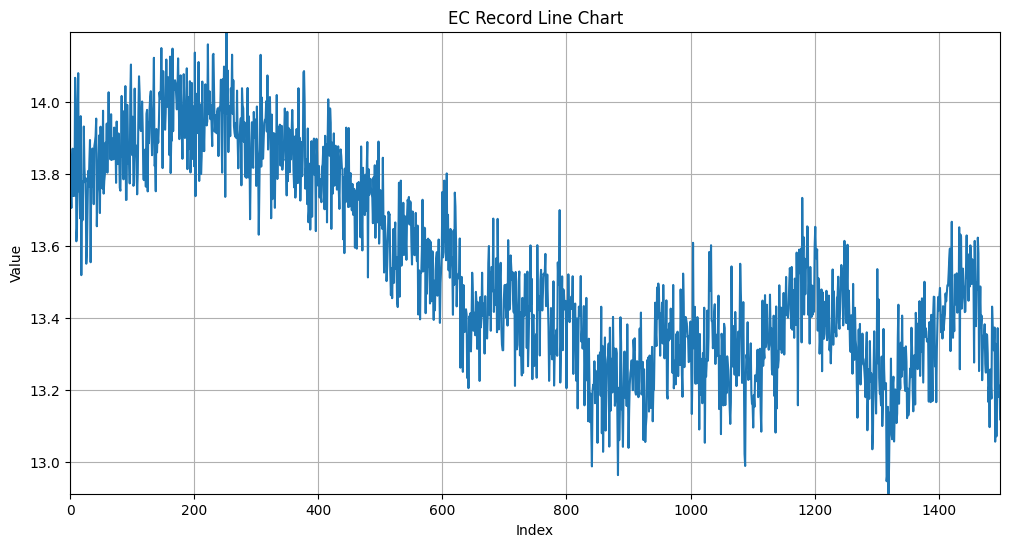

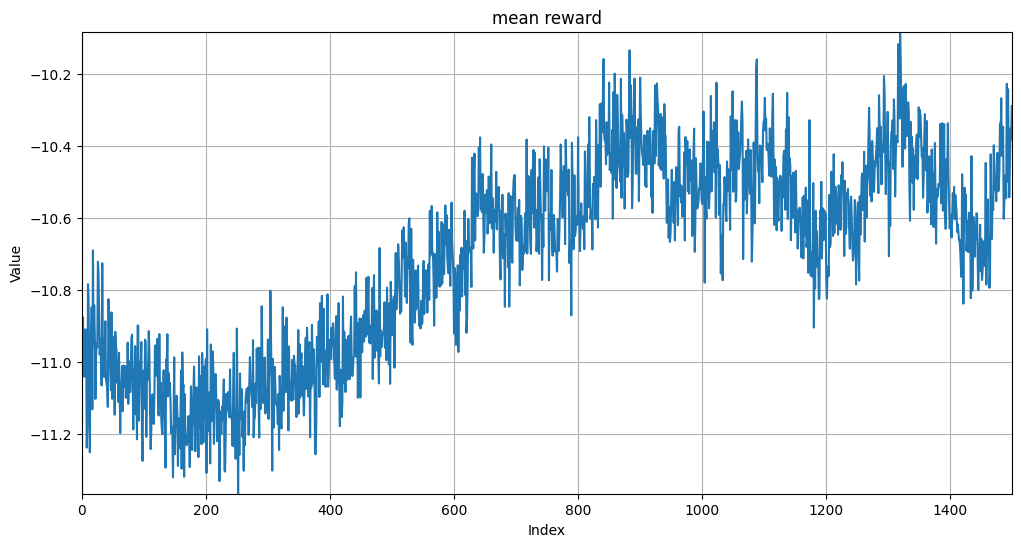

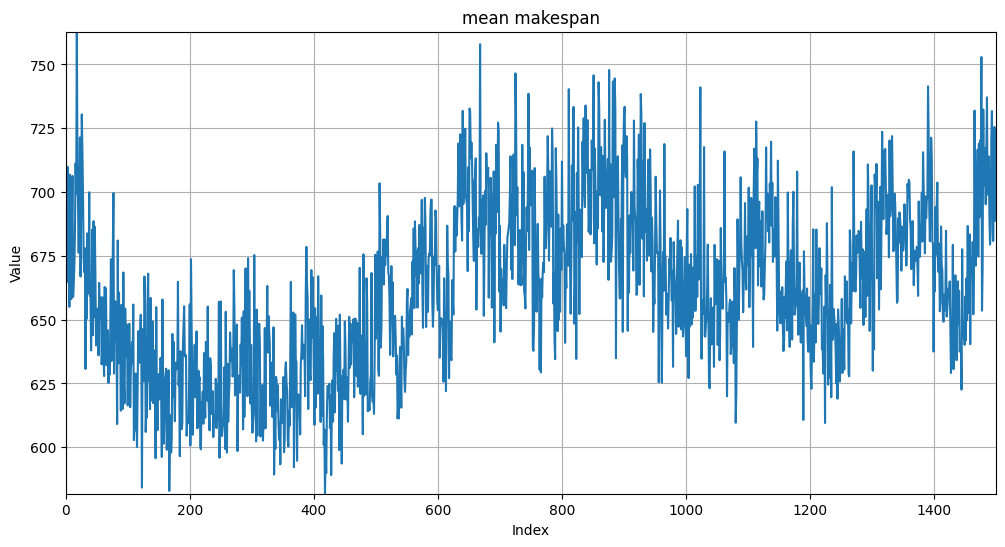

In [8]:
configs = parser.parse_args(args=[
    "--logdir", "./runs/model_test/main_model",
    "--model_suffix", "free",
    "--max_updates", "1500",
    "--n_j", "10",
    "--n_m", "5",
    "--num_envs", "10",
    "--fea_j_input_dim", "12", 
    "--fea_m_input_dim", "9", 
    '--factor_Mk', "0.0",
    '--factor_Ec', "1.0"
    # '--high', '10'
    ])

trainer = DANTrainer(configs)

trainer.train()


In [7]:
def schedule_fjsp(problem):
    num_jobs = 6
    num_machines = 2
    schedule = [[0]*num_machines for _ in range(num_jobs)]

    # 计算每个工件每个工序的开始时间
    for job in problem:
        machine_1_time = 0
        machine_2_time = 0
        for i in range(num_jobs):
            machine_1_time += job[i][0]
            machine_2_time = max(machine_1_time, machine_2_time) + job[i][1]
            schedule[i] = [machine_1_time - job[i][0], machine_2_time - job[i][1]]

    return schedule

def calculate_energy(schedule, idle_energy=0.2, working_energy=1):
    total_energy = 0
    
    # 遍历每个工件的排程
    for job_schedule in schedule:
        # 遍历每个工序
        for machine, start_time in enumerate(job_schedule):
            # 如果工序开始时间为0，则不消耗能量
            if start_time == 0:
                continue
            # 否则，工作机器消耗能量
            total_energy += working_energy
    
    # 计算机器空闲能量消耗
    total_energy += idle_energy * len(schedule[0]) * len(schedule)
    
    return total_energy

# 定义问题数据
problems = [
    [[0, 84], [58, 87], [98, 0], [0, 74], [33, 0], [97, 0]],
    [[85, 0], [67, 0], [48, 62], [49, 8], [93, 53], [0, 86]]
]

# 对每个FJSP问题进行排程和能量计算
for idx, problem in enumerate(problems):
    schedule = schedule_fjsp(problem)
    energy_consumption = calculate_energy(schedule)
    print(f"FJSP问题 {idx+1} 的能量消耗为: {energy_consumption}")


TypeError: 'int' object is not subscriptable

-------------------------Training Setting-------------------------
source : SD2
model name :../trained_network/SD2/10x5+mix.pth
vali data :./data/data_train_vali/SD2/10x5+mix


progress:   0%|          | 0/21 [00:00<?, ?it/s][[ 0  0 71 27 81]
 [ 7 15 76 55 72]
 [ 0 44  0 56 26]
 [ 0 85  0  0 13]
 [19 82  0 52 45]
 [ 0 57 92 50  0]
 [ 4  0 12 22 90]
 [ 0  0 12  0 95]
 [ 0  0 88 15  0]
 [ 0 13  0  0  0]
 [ 0 62  0  0 48]
 [ 0  0 87 47  0]
 [ 0  0 26  0  0]
 [ 1  0  0  0  0]
 [69  0  0  0 61]
 [66 77 68 45  0]
 [ 8 89 71 14 29]
 [64  0  0  0  0]
 [ 0  0 59  0  0]
 [79  7 66 95 71]
 [ 0  0 77 77  0]
 [ 0 14 45  2 42]
 [79  0 88 64  0]
 [ 4 18 89 88 70]
 [98  0  3 19  0]
 [46 58 36 19 92]
 [47  0  0  0  0]
 [ 0  0 27  0  0]
 [11  0  0 59  0]
 [ 0 26 28 58  4]
 [79 86 60 49 57]
 [88 88  5 70 57]
 [61 10 67 34 70]
 [ 0 80 29  0  0]
 [ 4 49  4  0 92]
 [56  0  0 50 88]
 [86  0  0  0 67]
 [46 11  9 97 26]
 [ 0  0  0 71  0]
 [40  0 93 39  6]
 [10 41  0  0 22]
 [ 0  0  0 45  0]
 [ 0 82 62 15 79]
 

In [ ]:
np.array([[[48, 74, 33],
        [47, 97,  0],
        [84, 79, 37],
        [97, 81, 69],
        [ 0,  0, 68],
        [ 3, 85, 40],
        [67, 85, 48],
        [ 0, 49,  8],
        [93, 53, 98],
        [86,  0, 28],
        [35, 98, 77],
        [41,  0, 70],
        [65,  0,  0],
        [ 0, 11, 23],
        [78, 19, 16]],

       [[49,  0, 92],
        [50, 87,  4],
        [68, 12,  0],
        [90, 99,  0],
        [12,  4, 95],
        [ 7,  0,  0],
        [15,  0,  0],
        [13, 55,  0],
        [ 0,  0, 62],
        [75, 66, 48],
        [ 0,  6, 87],
        [47,  0, 60],
        [41,  0,  0],
        [50,  0, 36],
        [30,  2,  0]]])